In [3]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from libpysal.weights import DistanceBand
from shapely.geometry import Point
import splot.esda
import esda
import libpysal

In [4]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import KMeans

# Generate 100 points in a 10x10 grid
n = 10
x = (np.arange(n * n) % n) * 0.1 + 0.05
y = (np.arange(n * n) // n) * 0.1 + 0.05
points = np.column_stack((x, y))

# Create GeoDataFrame
geometry = [Point(p) for p in points]
gdf = gpd.GeoDataFrame(geometry=geometry, crs="EPSG:4326")

In [5]:
gdf['HH'] = np.concatenate((np.random.normal(size=75, loc=5, scale=0.5), np.random.normal(size=25, loc=0.5, scale=1.25)))
gdf['LL'] = np.concatenate((np.random.normal(size=75, loc=0.5, scale=0.5), np.random.normal(size=25, loc=5, scale=1.25)))

xarr = np.random.normal(size=100, loc=0.5, scale=0.15)
yarr = np.random.normal(size=100, loc=10, scale=0.15)
count = [n for n in range(100)]

some_list = []
switch = True

for c, x, y in zip(count, xarr, yarr):
    if c % 5 == 0:
        if switch:
            switch = False
        else:
            switch = True
    
    if switch:
        some_list.append(x)
        some_list.append(y)
    else:
        some_list.append(y)
        some_list.append(x)

gdf['HL'] = some_list[:75] + list(np.random.normal(size=25, loc=5, scale=2.5))
gdf['LH'] = some_list[100:175] + list(np.random.normal(size=25, loc=5, scale=2.5))

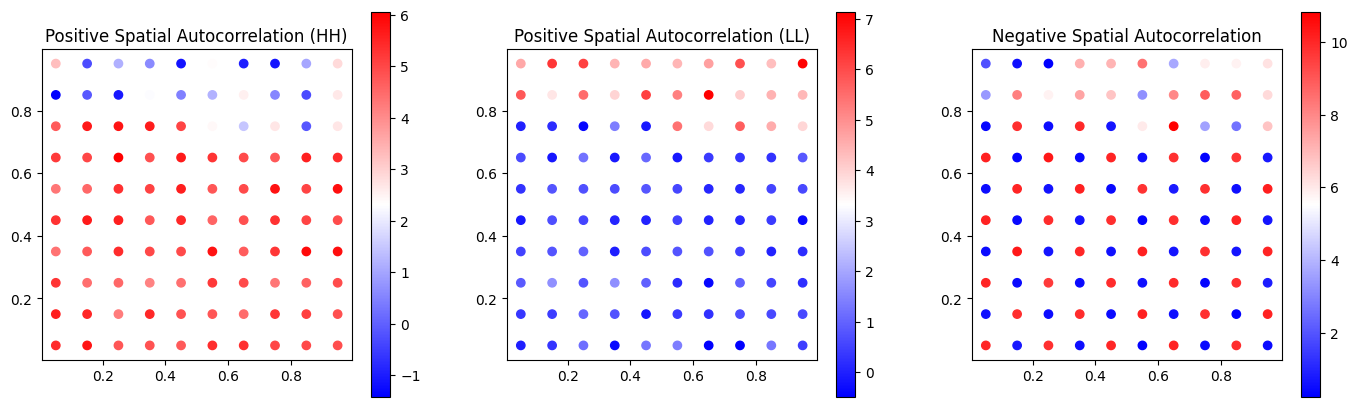

In [21]:
# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

gdf.plot(
    ax=axes[0],
    column='HH',
    legend=True,
    cmap='bwr'
)
axes[0].set_title('Positive Spatial Autocorrelation (HH)')
gdf.plot(
    ax=axes[1],
    column='LL',
    legend=True,
    cmap='bwr'
)
axes[1].set_title('Positive Spatial Autocorrelation (LL)')
gdf.plot(
    ax=axes[2],
    column='LH',
    legend=True,
    cmap='bwr'
)
axes[2].set_title('Negative Spatial Autocorrelation')
# gdf.plot(
#     ax=axes[1,1],
#     column='HL',
#     legend=True,
#     cmap='bwr'
# )
# axes[1,1].set_title('High-Low (HL) Data')

plt.show()

/tmp/ipykernel_22071/1799428605.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Rook.from_dataframe(gdf[[col, 'geometry']])


Morans I: 0.711055
p-value: 0.001


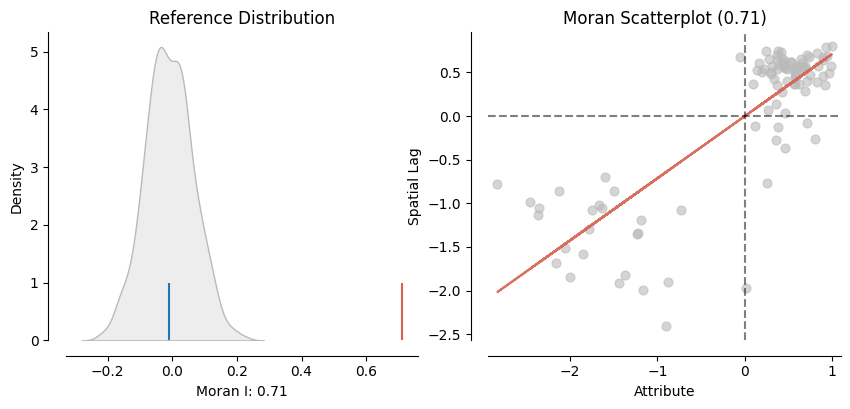

/tmp/ipykernel_22071/1799428605.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Rook.from_dataframe(gdf[[col, 'geometry']])


Morans I: 0.786029
p-value: 0.001


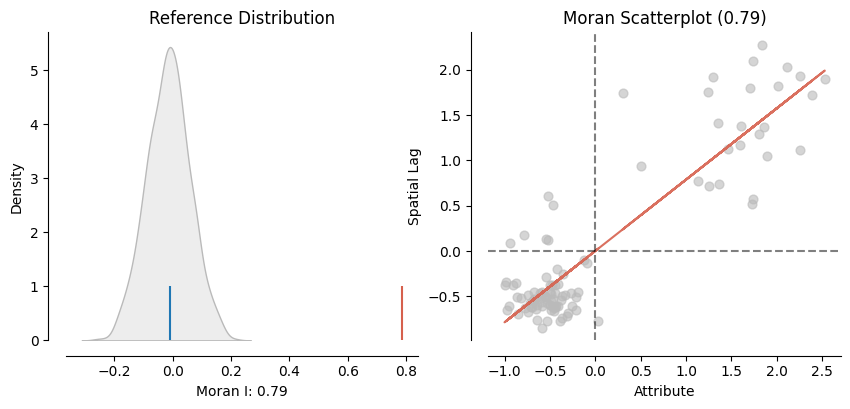

Morans I: -0.874399
p-value: 0.001


/tmp/ipykernel_22071/1799428605.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Rook.from_dataframe(gdf[[col, 'geometry']])


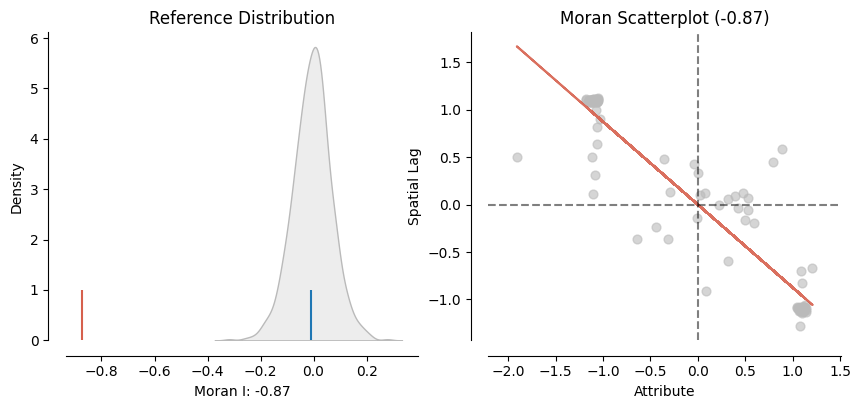

Morans I: -0.867875
p-value: 0.001


/tmp/ipykernel_22071/1799428605.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Rook.from_dataframe(gdf[[col, 'geometry']])


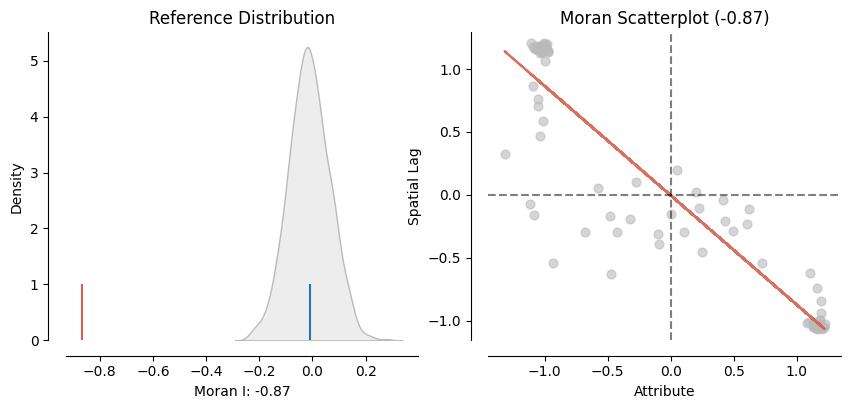

In [269]:
cols = [col for col in gdf.columns if col != 'geometry']
for col in cols:
    w = libpysal.weights.Rook.from_dataframe(gdf[[col, 'geometry']])
    w.transform = 'R'
    morans_stat = esda.moran.Moran(gdf[col], w)
    print(f'Morans I: {morans_stat.I:.6}')
    print(f'p-value: {morans_stat.p_sim}')
    splot.esda.plot_moran(morans_stat)
    plt.show()

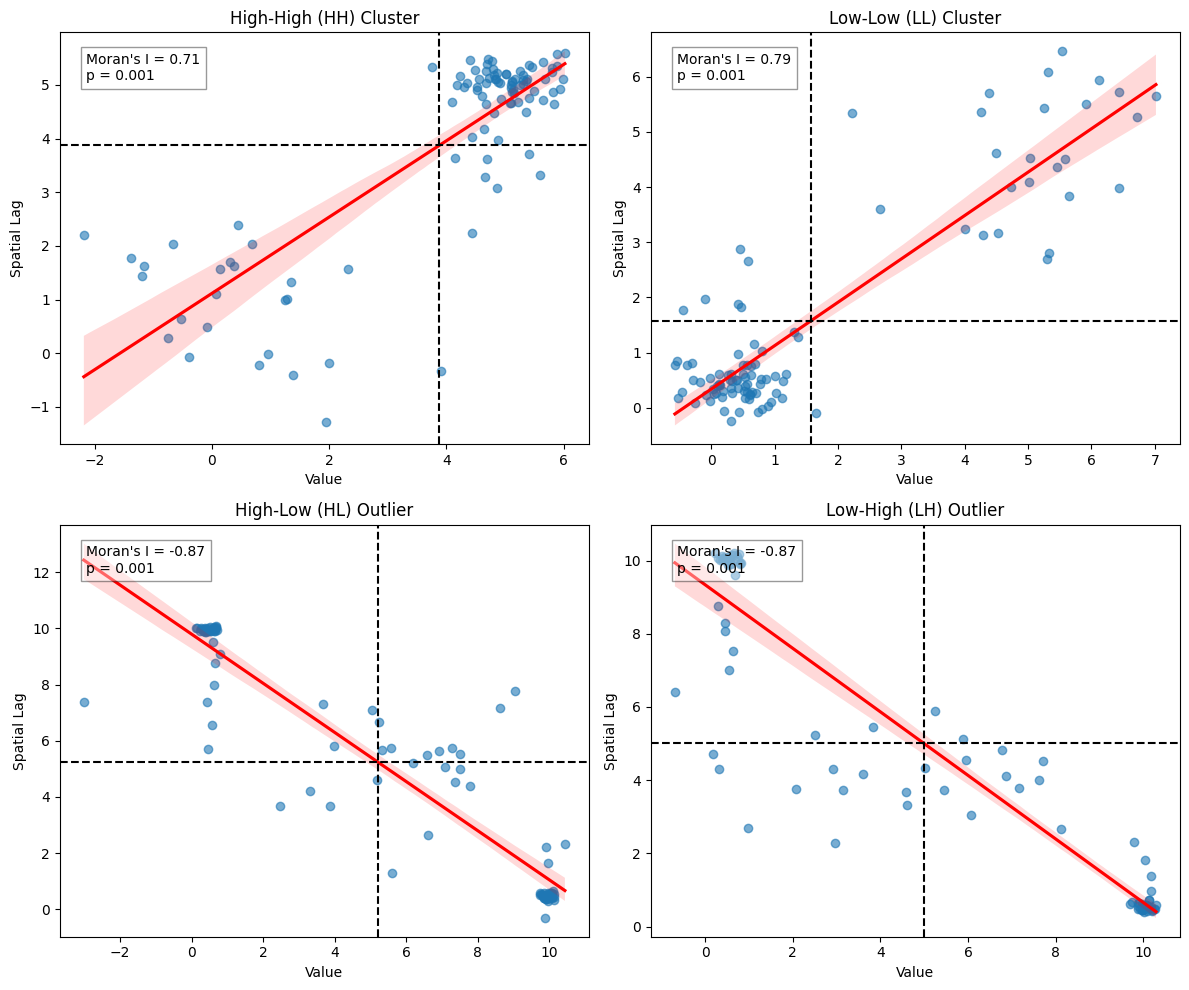

In [270]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from libpysal.weights import lag_spatial

def create_moran_scatterplot(gdf, title, ax, col):
    """Create a Moran scatterplot with trend line for a GeoDataFrame"""
    # Calculate spatial lag
    w = libpysal.weights.Rook.from_dataframe(gdf[[col, 'geometry']], use_index=False)
    w.transform = 'R'
    y = gdf[col]
    y_lag = lag_spatial(w, y)
    
    # Create DataFrame for plotting
    plot_data = pd.DataFrame({'y': y, 'y_lag': y_lag})
    
    # Create scatterplot with regression line
    sns.regplot(x='y', y='y_lag', data=plot_data, 
                scatter_kws={'alpha': 0.6}, 
                line_kws={'color': 'red'}, 
                ax=ax)
    
    # Add reference lines
    ax.axhline(y=y.mean(), color='k', linestyle='--')
    ax.axvline(x=y.mean(), color='k', linestyle='--')
    
    # Add labels and title
    ax.set_xlabel('Value')
    ax.set_ylabel('Spatial Lag')
    ax.set_title(title)
    
    # Calculate and display Moran's I in the plot
    moran = esda.moran.Moran(gdf[col], w)
    ax.text(0.05, 0.95, f"Moran's I = {moran.I:.2f}\np = {moran.p_sim}",
            transform=ax.transAxes, va='top',
            bbox=dict(facecolor='white', alpha=0.4))

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Generate scatterplots for each pattern
create_moran_scatterplot(gdf, "High-High (HH) Cluster", axes[0,0], 'HH')
create_moran_scatterplot(gdf, "Low-Low (LL) Cluster", axes[0,1], 'LL')
create_moran_scatterplot(gdf, "High-Low (HL) Outlier", axes[1,0], 'HL')
create_moran_scatterplot(gdf, "Low-High (LH) Outlier", axes[1,1], 'LH')

plt.tight_layout()
plt.show()